<a href="https://colab.research.google.com/github/alixintong/btt-ai-know-your-customer/blob/bless/OCR_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# this cell allows access to our folder

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_path = '/content/gdrive/MyDrive/BTTAI_AmericanExpress1'

Mounted at /content/drive


# Libraries

In [2]:
# cell for imports - add as needed
import torch 
import cv2
import numpy as np 
import pandas as pd
import os, os.path
import re
from fastai.vision.all import *
from PIL import Image
from google.colab.patches import cv2_imshow
from skimage import io
from matplotlib import pyplot as plt
import imutils

In [3]:
# reference tutorial for classification: https://docs.fast.ai/23_tutorial.vision.html

In [4]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!sudo apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [5]:
from PIL import Image
from pytesseract import pytesseract

# Reading and Displaying images

(1080, 1920, 3)


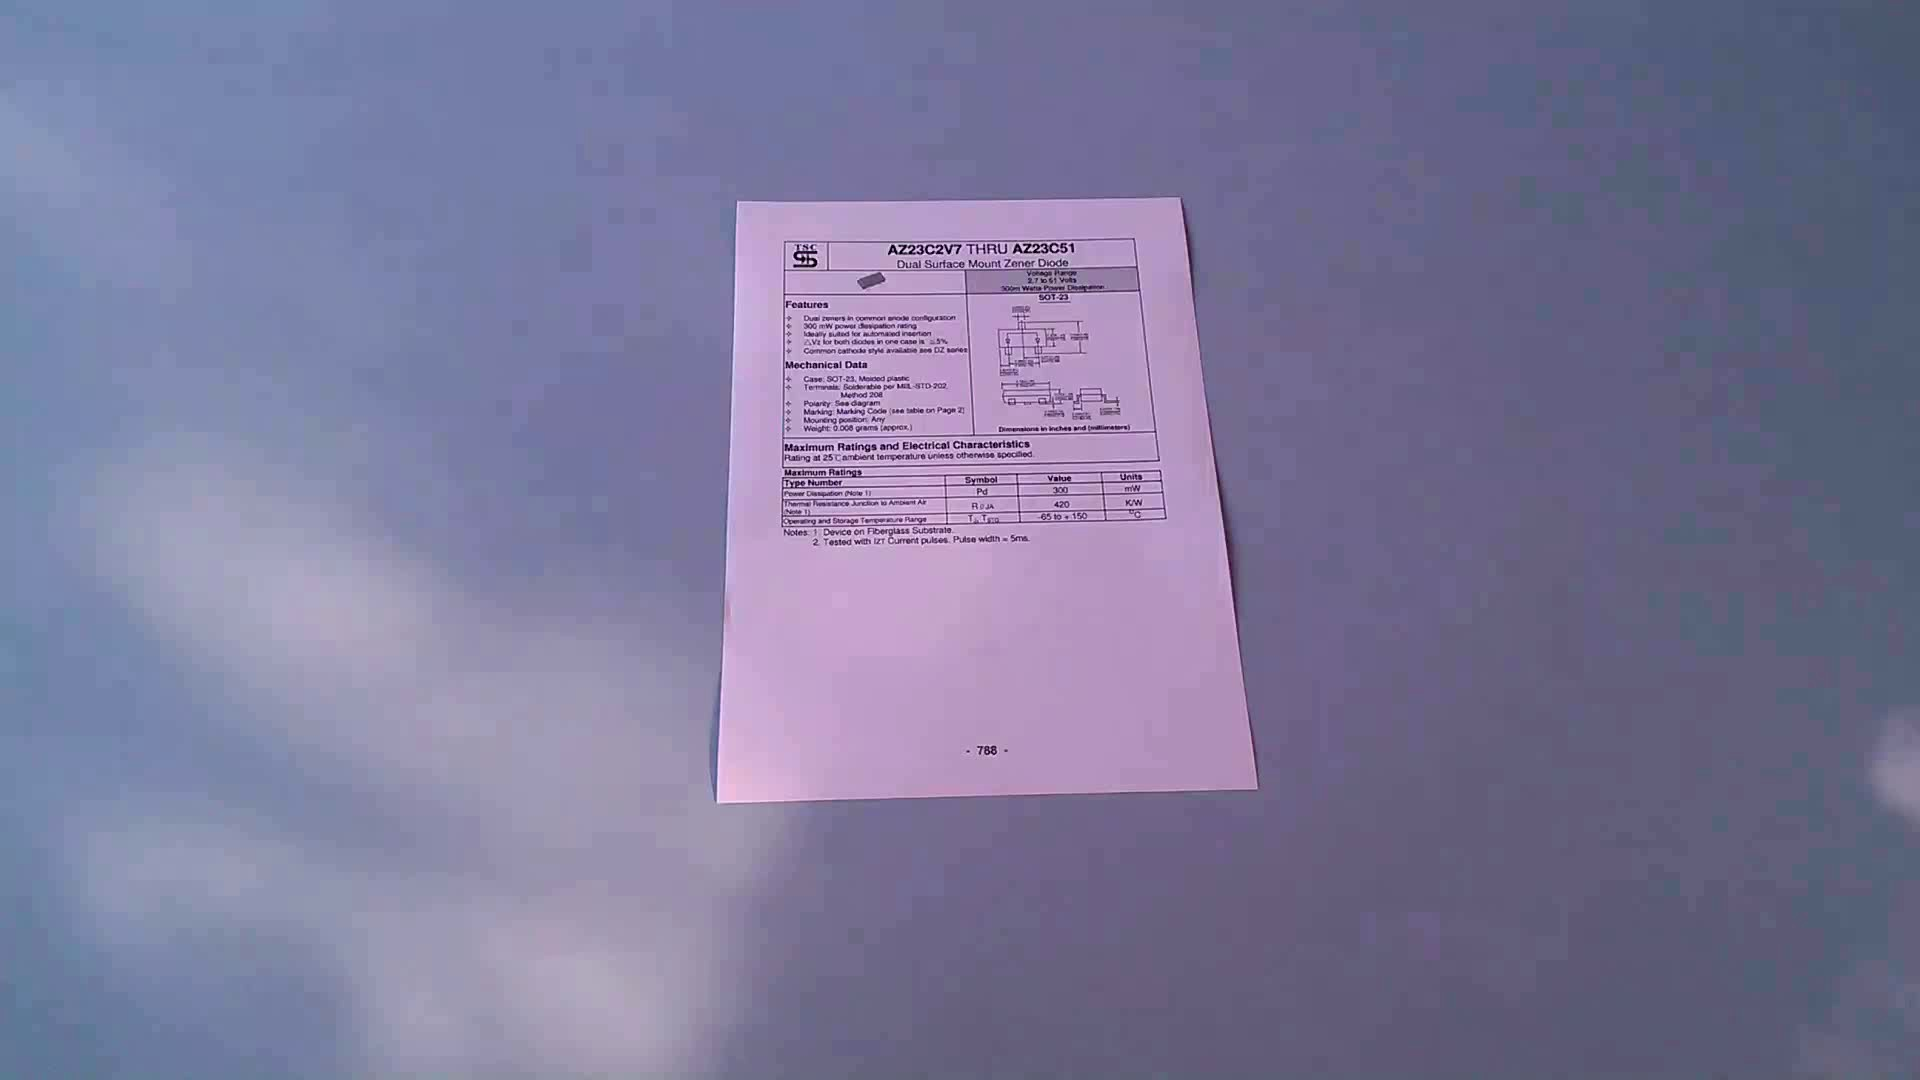

In [6]:


im = '/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/datasheet001_frames/datasheet001_frames_00001.jpg'
img = cv2.imread(im) #read image
print(img.shape) # Print image shape
cv2_imshow(img) #show image

In [7]:
img.shape[1]

1920

Cropping the actual document in the frame using OpenCv

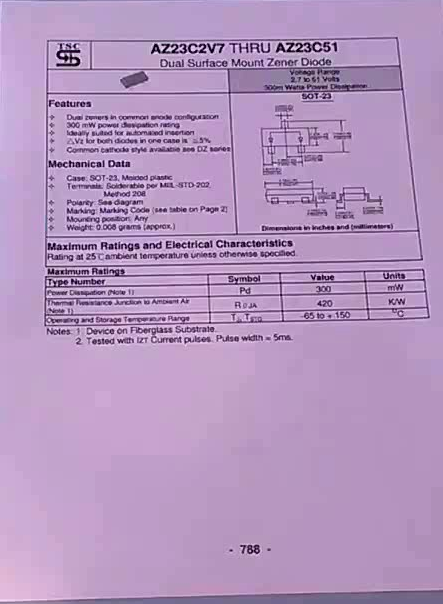

True

In [8]:
# Cropping an image
cropped_image = img[201:805, 737:1180] #the number is the bounding box from thr groundtruth file

# Display cropped image
cv2_imshow(cropped_image)

#saving cropped image
cv2.imwrite('image1.png',cropped_image) #this is saved on your local google colab environment

In [9]:
#Don't need this just for reference
#img1 = Image.open(im)
#img2 = img1.crop((0, 0, 201, 335))
#img2.save("img2.jpg")

Changing the image color to grayscale

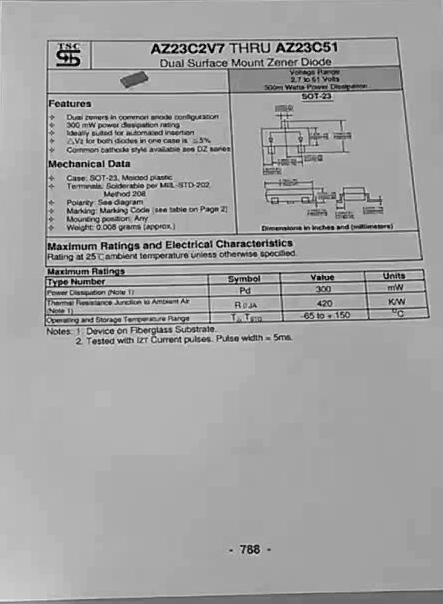

In [10]:
img_gray = cv2.imread('/content/image1.png', cv2.IMREAD_GRAYSCALE) #reading image and changing the color to grayscale

cv2.imwrite('/content/image2.png', img_gray) #saving image
cv2_imshow(img_gray) #displaying image

# Sharpening Image

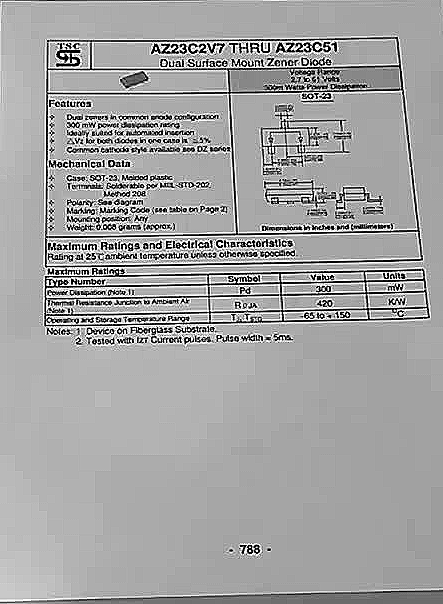

In [11]:
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
img_gray_sharp = cv2.filter2D(src=img_gray, ddepth=-1, kernel=kernel)
cv2_imshow(img_gray_sharp)

# Preprocessing Technique
https://nanonets.com/blog/ocr-with-tesseract/#tesseract-ocr

In [12]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY) #+ cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

In [13]:
test = cv2.imread('/content/test_img.png')

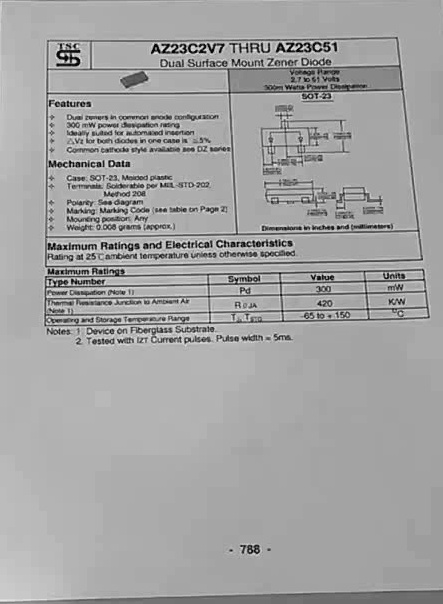

In [14]:
img_gray2 = get_grayscale(cropped_image)
cv2_imshow(img_gray2)

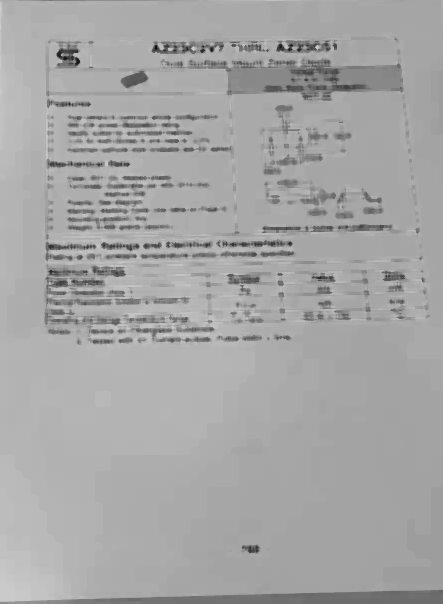

In [15]:
img_rem_noise = remove_noise(img_gray2)
cv2_imshow(img_rem_noise)

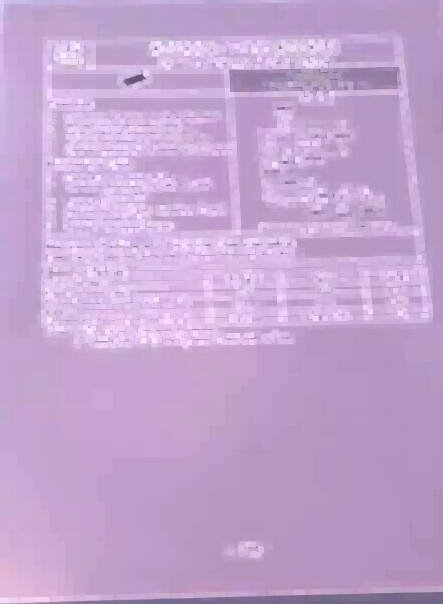

In [16]:
img_dilate = dilate(cropped_image)
cv2_imshow(img_dilate)

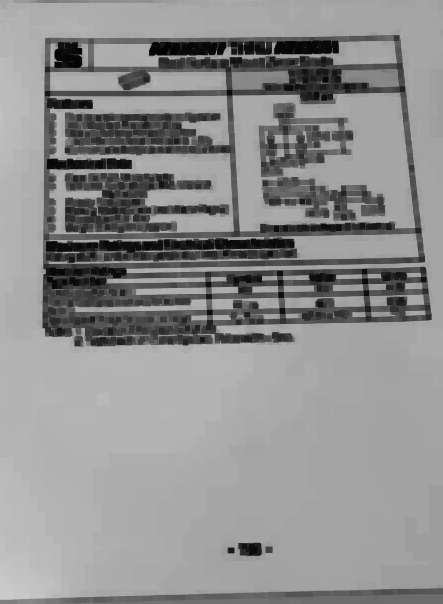

In [17]:
img_erode = erode(img_gray2)
cv2_imshow(img_erode)

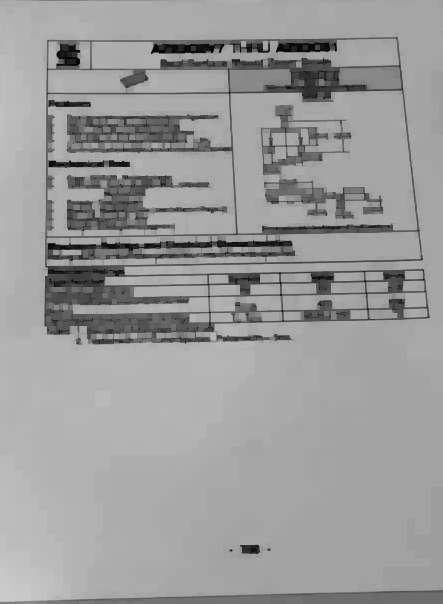

In [18]:
img_opening = opening(img_gray2)
cv2_imshow(img_opening)

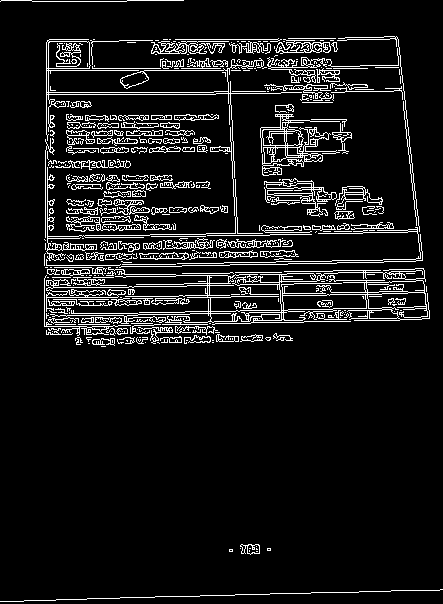

In [19]:
img_canny = canny(img_gray2)
cv2_imshow(img_canny)

# Extracting text from image using Pytesseract

Pytesseract Functions
https://pypi.org/project/pytesseract/

In [20]:
#image to string
print(pytesseract.image_to_string(Image.open('/content/test_img.png')))

SOP Template

= Version #1.0
@ Approved by: @Name

™ Date:

Purpose

Include a simple statement regarding why you are writing this document. It may also be

helpful to describe the purpose of the subject matter in the SOP.

Scope

| This describes to whom or under what circumstances (or both) the document applies.

Definitions/Acronyms

First term: Definition of first term.

Second term: Definition of second term.

Procedures
| Describe the process in detail using flow charts and/or hierarchical checklists.

Step 1:
Step 1.1:
Step 1.2:

Step 2:

Related resources

Include references and links to relevant materials which may be helpful for executing the

process.



In [21]:
# Get bounding box estimates
print(pytesseract.image_to_boxes(Image.open('/content/test_img.png')))

S 89 1808 118 1853 0
O 128 1808 151 1853 0
P 176 1808 200 1853 0
T 228 1808 250 1853 0
e 263 1808 283 1842 0
m 283 1808 294 1842 0
p 319 1808 346 1842 0
l 357 1795 385 1842 0
a 391 1808 398 1853 0
t 415 1808 432 1842 0
e 445 1808 491 1850 0
= 92 1707 109 1732 0
V 124 1707 131 1727 0
e 131 1707 140 1727 0
r 145 1707 154 1722 0
s 158 1707 167 1722 0
i 171 1707 185 1729 0
o 189 1707 198 1722 0
n 207 1707 218 1722 0
# 229 1707 238 1728 0
1 238 1707 243 1728 0
. 251 1707 265 1727 0
0 269 1707 282 1727 0
@ 87 1653 108 1682 0
A 124 1658 132 1678 0
p 132 1658 141 1678 0
p 147 1652 157 1673 0
r 163 1652 175 1673 0
o 179 1658 187 1673 0
v 195 1658 213 1673 0
e 213 1658 218 1673 0
d 225 1658 246 1680 0
b 259 1658 271 1680 0
y 275 1652 289 1673 0
: 291 1658 296 1674 0
@ 305 1653 329 1678 0
N 333 1658 347 1678 0
a 351 1658 363 1673 0
m 368 1658 382 1673 0
e 392 1658 405 1673 0
™ 88 1623 111 1633 0
D 126 1609 131 1629 0
a 131 1609 142 1629 0
t 145 1609 157 1624 0
e 160 1609 169 1629 0
: 174 1609 191

In [22]:
#image data
#I am not sure ho to interpret this
print(pytesseract.image_to_data(Image.open('/content/test_img.png')))

level	page_num	block_num	par_num	line_num	word_num	left	top	width	height	conf	text
1	1	0	0	0	0	0	0	1400	1962	-1	
2	1	1	0	0	0	89	109	402	58	-1	
3	1	1	1	0	0	89	109	402	58	-1	
4	1	1	1	1	0	89	109	402	58	-1	
5	1	1	1	1	1	89	109	119	45	96	SOP
5	1	1	1	1	2	228	109	263	58	96	Template
2	1	2	0	0	0	87	230	318	80	-1	
3	1	2	1	0	0	87	230	318	80	-1	
4	1	2	1	1	0	92	230	190	25	-1	
5	1	2	1	1	1	92	230	22	25	93	=
5	1	2	1	1	2	124	233	96	22	92	Version
5	1	2	1	1	3	229	234	53	21	92	#1.0
4	1	2	1	2	0	87	280	318	30	-1	
5	1	2	1	2	1	87	280	29	29	0	@
5	1	2	1	2	2	124	282	125	28	96	Approved
5	1	2	1	2	3	259	282	37	28	92	by:
5	1	2	1	2	4	305	284	100	25	90	@Name
2	1	3	0	0	0	88	329	103	24	-1	
3	1	3	1	0	0	88	329	103	24	-1	
4	1	3	1	1	0	88	329	103	24	-1	
5	1	3	1	1	1	88	329	27	10	83	™
5	1	3	1	1	2	126	333	65	20	96	Date:
2	1	4	0	0	0	90	451	179	46	-1	
3	1	4	1	0	0	90	451	179	46	-1	
4	1	4	1	1	0	90	451	179	46	-1	
5	1	4	1	1	1	90	451	179	46	96	Purpose
2	1	5	0	0	0	118	545	1111	28	-1	
3	1	5	1	0	0	118	545	1111	28	-1	
4	1	5	1	1	0	118	545	1